In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch import optim
from tqdm import tqdm
import os

from util.train_model import ModelTrainer
from util.function import *

from model.gru_base import GRUModel

In [2]:
set_seed(0)

Set random seed as 0 for pytorch


# 1.数据加载

## 1.1参数设置

In [3]:
train_start_date = '2012-01-01'
train_end_date =   '2016-12-31'
test_start_date =  '2017-01-01'
test_end_date =    '2017-12-31'
test_final_date = '2024-08-31'
seq_len = 40 
step = 5
batch_size = 5000

## 1.2数据预处理

In [7]:
def RawData_Preprocess(df,
                       drop_ratio: float = (2/3),
                       ret_muti_index: bool = True,
                       label_is_normal: bool = True):
    # 先按法则去除部分行
    # 未缺失比例少于2/3的行进行剔除，再剔除 y 缺失的行，剩下的特征 nan 值用0值填充
    df = df.dropna(thresh=int((df.shape[1]-1)*drop_ratio),axis = 0)
    df = df.dropna(subset=['return'])
    df = df.fillna(0)
    df = df.reset_index()
    # 标签is_normal处理
    if label_is_normal:
        df['return'] = df.groupby('datetime')['return'].apply(lambda x: (x-x.mean())/x.std() if x.std() != 0 else (x-x.mean()))
    # 是否返回双重index的df格式
    if ret_muti_index:
        df.set_index(['datetime','stock_code'],inplace=True)
    return df

In [8]:
raw_data = pd.read_parquet(
    '/home/chenglei/higgs_quant/fin_con_ML_factor/data/factors/df_factor52_20d_return_120101_240831.par')
raw_data = RawData_Preprocess(raw_data,
                              drop_ratio=(2/3),
                              ret_muti_index=False,
                              label_is_normal=True)


In [9]:
raw_data

,datetime,stock_code,con_np_yoy_rank_0_neg,con_npgrate_13w_n1_neg,con_peg_0_neg,con_na_0_neg,con_eps_0_neg,con_pe_n1_neg,con_np_0_neg,con_or_yoy_rank_0_neg,...,DividendCover,DividendPaidRatio,OperCashFlowPS,DilutedEPS,PEIndu,PBIndu,PSIndu,PCFIndu,CETOP,return
0,2012-01-04,000001.SZ,-1.596669,0.051041,0.219036,0.171563,-2.017405,0.469378,0.211076,-1.579931,...,0.000000,0.000000,0.865321,2.440136,-0.695371,-0.775695,-0.558440,-0.692105,0.572214,0.439337
1,2012-01-04,000002.SZ,-0.372734,-0.049687,0.178856,-8.439709,-1.406188,-0.032110,-8.637513,-0.935532,...,0.059121,-0.364303,0.458471,0.497070,-0.556924,-0.573825,-0.552929,0.343657,0.435409,-0.354886
2,2012-01-04,000004.SZ,1.208983,1.397304,-10.586397,0.705467,1.166688,-2.834055,0.738565,1.611798,...,0.000000,0.000000,-0.056049,-1.046805,3.290376,2.288129,0.262868,-0.218869,0.085373,0.150825
3,2012-01-04,000005.SZ,1.262926,-0.045737,0.166415,0.431885,0.973001,-0.255797,0.413711,1.321765,...,0.000000,0.000000,0.340639,-0.745265,0.946819,1.313876,2.296941,2.228746,0.365818,-0.710117
4,2012-01-04,000006.SZ,-0.075310,-0.073843,0.175828,0.030088,-0.523711,-0.027530,-0.076780,0.086311,...,0.879642,-0.531766,1.902809,0.301332,-0.653203,-0.713674,-0.561035,-0.813134,2.571459,0.547897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10629363,2024-08-02,688799.SH,-0.822800,0.006269,0.218363,0.378478,-1.618167,0.047904,0.161343,-0.839119,...,-0.133563,-0.054955,0.923573,0.476730,-0.741670,-0.232393,-0.618071,-0.454230,0.159993,0.177083
10629364,2024-08-02,688800.SH,-0.940738,0.040583,0.213413,0.229518,-0.652248,-0.034975,0.117155,-1.034376,...,1.337435,-0.560731,-0.003016,1.548602,-0.674112,-0.653834,-0.712350,-0.141632,-0.127984,-0.832532
10629365,2024-08-02,688819.SH,-0.175887,0.003244,0.301439,-0.695456,-1.267282,0.078486,-0.625492,-0.186072,...,0.117478,-0.166550,1.516376,1.028974,-0.809933,-0.698496,-0.991244,-0.777734,1.228493,1.556719
10629366,2024-08-02,688981.SH,0.041221,0.037566,-0.440526,-9.245888,0.157797,-0.067087,-2.225524,0.490785,...,0.000000,0.000000,1.525152,-0.187672,0.593681,-0.223262,0.696562,-0.648531,0.364585,0.229532


# 2.滚动模型

## 2.1模型设置

In [10]:
try_label = 'gru_10_28_factor52_v1_y_normal'

## 2.2滚动函数

In [11]:
def gru_model_rolling(df,
                      train_start_date: str,
                      train_end_date: str,
                      test_start_date: str,
                      test_end_date: str,
                      test_final_date: str,
                      jump: int,
                      times: int,
                      train_period_years: int,
                      batch_size: int,
                      try_label: str,
                      sep_len: int,
                      step: int):
    """输入数据和模型，以及滚动训练的时间和规则设置，完成滚动训练

    Args:
        df (DataFrame): 全数据
        train_start_date (str): 训练集开始日期
        train_end_date (str): 训练集结束日期
        test_start_date (str): 测试集开始日期
        test_end_date (str): 测试集结束日期
        test_final_date (str): 测试集最终日期，如果测试集结束日期超过测试集最终日期，则被职位测试集最终日期
        jump (int): 相邻滚动的年数间隔，如为 1 则，每次滚动数据往后推迟一年
        times (int): 滚动训练的总次数
        train_period_years: 训练集年数，如果按照规律滚动时训练集年数少于给定值，则会固定训练集开始年份不变，直至训练集年数达到给定值
        batch_size: 训练单个批次的大小
        try_label: 此次模型的标记
        sep_len: 单个样本的时间步数
        step: 采样间隔

    Returns:
        _type_: 所有滚动训练合并的预测值（pivotal 格式），损失 loss
    """
    dict_date = {'train_start_date': train_start_date,
                 'train_end_date': train_end_date,
                 'test_start_date': test_start_date,
                 'test_end_date': test_end_date}

    y_pred_list = []
    loss_list = []
    for k in tqdm(range(times),desc="outer", colour='red'):

        # 计算当次训练的训练日期和测试日期
        list_date_temp = [pd.to_datetime(
            s)+pd.DateOffset(years=jump if k > 0 else 0) for s in list(dict_date.values())]

        from dateutil.relativedelta import relativedelta
        if relativedelta(list_date_temp[2], list_date_temp[0]).years < train_period_years:
            list_date_temp[0] = pd.to_datetime(dict_date['train_start_date'])

        if list_date_temp[-1] > pd.to_datetime(test_final_date):
            list_date_temp[-1] = pd.to_datetime(test_final_date)

        list_date_temp = [date.strftime('%Y-%m-%d') for date in list_date_temp]
        dict_date_temp = dict(zip(dict_date.keys(), list_date_temp))

        # 获取训练测试数据,特征已做标准化
        x1_train, x1_valid, X_test, y_train, y_valid, y_test, train_date, test_date, sample_stock = gru_dataloader(df=df,
                                                                                                                   **dict_date_temp,
                                                                                                                   seq_len=seq_len,
                                                                                                                   step=step)
        train_ds = Newdataset(x1_train, y_train)
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=False)

        valid_ds = Newdataset(x1_valid, y_valid)
        valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

        # 训练标签
        try_label_current = try_label + '_' + \
            dict_date_temp['train_start_date'] + \
            '_' + dict_date_temp['train_end_date']
        model = GRUModel(input_num=52,
                         hidden_num=32)

        # 模型设置和训练
        optimizer = optim.Adam(model.parameters(), lr=0.005)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        modeltrainer = ModelTrainer(
            model, optimizer, device, name=try_label_current)
        train_ic_list, val_ic_list = modeltrainer.fit_rolling(
            train_dl, valid_dl, 'data')

        # 加载存储的最佳模型
        model = torch.load(f'data/saved_model/{try_label_current}.pt')
        modeltrainer = ModelTrainer(
            model, optimizer, device, name=try_label_current)

        # 预测
        y_pred = predict_test_set(X_test=X_test,
                                  y_test=y_test,
                                  modeltrainer=modeltrainer,
                                  test_date=test_date,
                                  sample_stock=sample_stock,
                                  seq_len=seq_len)
        y_pred_list.append(y_pred)

        # loss计算
        loss = round(max(val_ic_list), 4)
        loss_list.append(loss)

        # 更新日期字典
        dict_date = dict_date_temp

    # 合并所有滚动的预测结果
    y_pred = pd.concat(y_pred_list)
    # 计算平均误差
    loss = np.mean(loss_list)

    return y_pred, loss


## 2.3训练&预测

100%|██████████| 52/52 [00:50<00:00,  1.03it/s]


gru_10_28_factor52_v1_y_normal_2012-01-01_2016-12-31
Set random seed as 0 for pytorch


100%|██████████| 52/52 [01:08<00:00,  1.33s/it]6s/it]


gru_10_28_factor52_v1_y_normal_2012-01-01_2017-12-31
Set random seed as 0 for pytorch


100%|██████████| 52/52 [01:14<00:00,  1.44s/it]1s/it]


gru_10_28_factor52_v1_y_normal_2012-01-01_2018-12-31
Set random seed as 0 for pytorch


100%|██████████| 52/52 [01:39<00:00,  1.91s/it]0s/it]


gru_10_28_factor52_v1_y_normal_2012-01-01_2019-12-31
Set random seed as 0 for pytorch


100%|██████████| 52/52 [01:47<00:00,  2.07s/it]4s/it]


gru_10_28_factor52_v1_y_normal_2013-01-01_2020-12-31
Set random seed as 0 for pytorch


100%|██████████| 52/52 [01:52<00:00,  2.17s/it]5s/it]


gru_10_28_factor52_v1_y_normal_2014-01-01_2021-12-31
Set random seed as 0 for pytorch


100%|██████████| 52/52 [02:10<00:00,  2.51s/it]6s/it]


gru_10_28_factor52_v1_y_normal_2015-01-01_2022-12-31
Set random seed as 0 for pytorch


100%|██████████| 52/52 [02:14<00:00,  2.58s/it]4s/it]


gru_10_28_factor52_v1_y_normal_2016-01-01_2023-12-31
Set random seed as 0 for pytorch


outer: 100%|██████████| 8/8 [33:28<00:00, 251.05s/it]


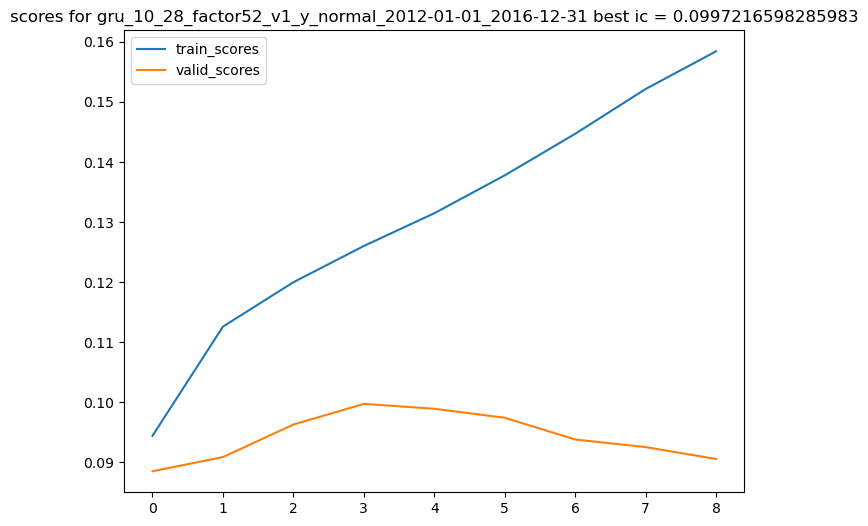

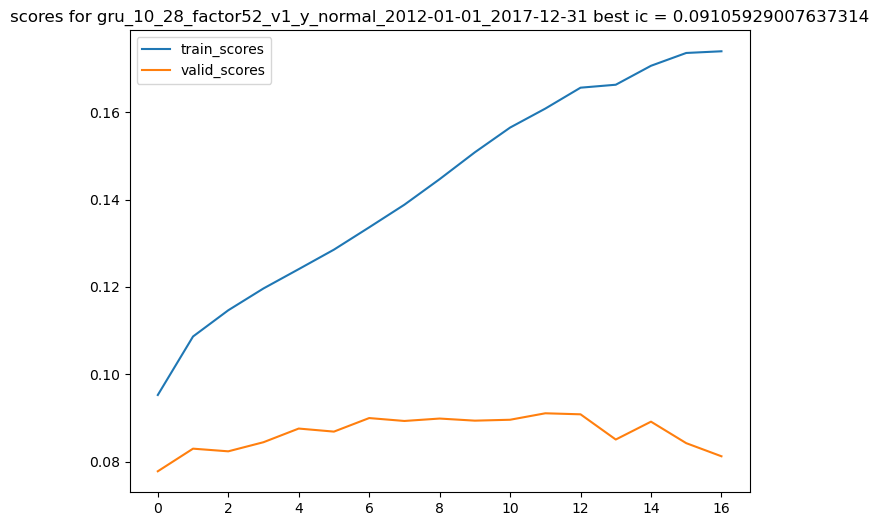

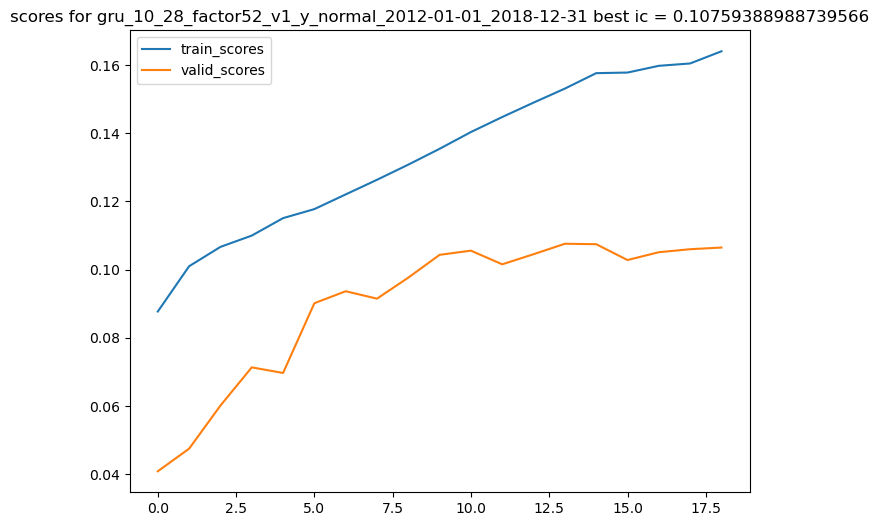

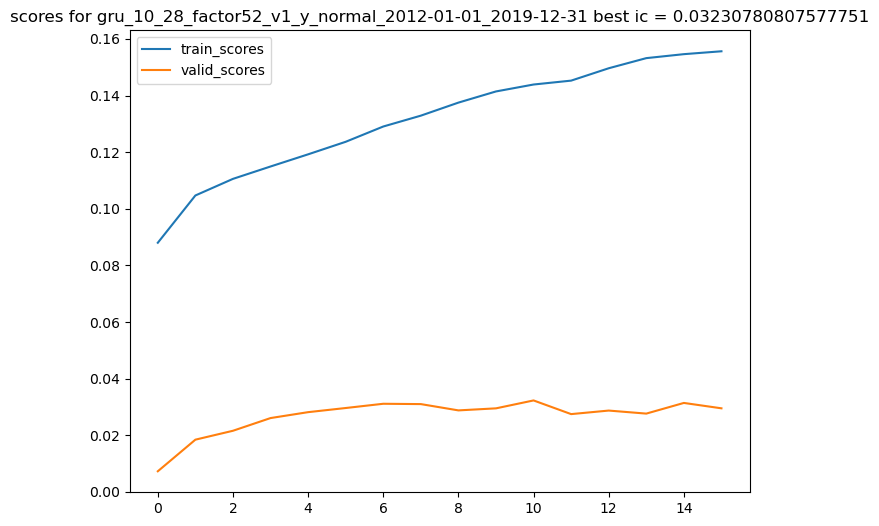

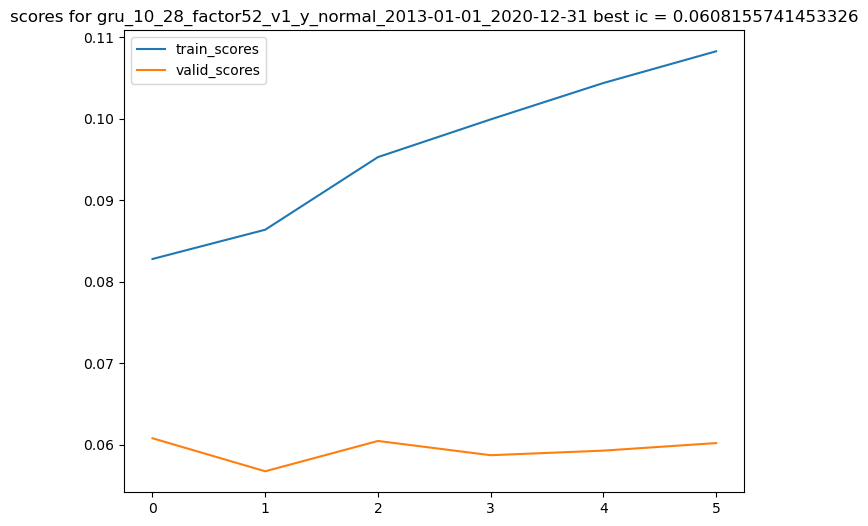

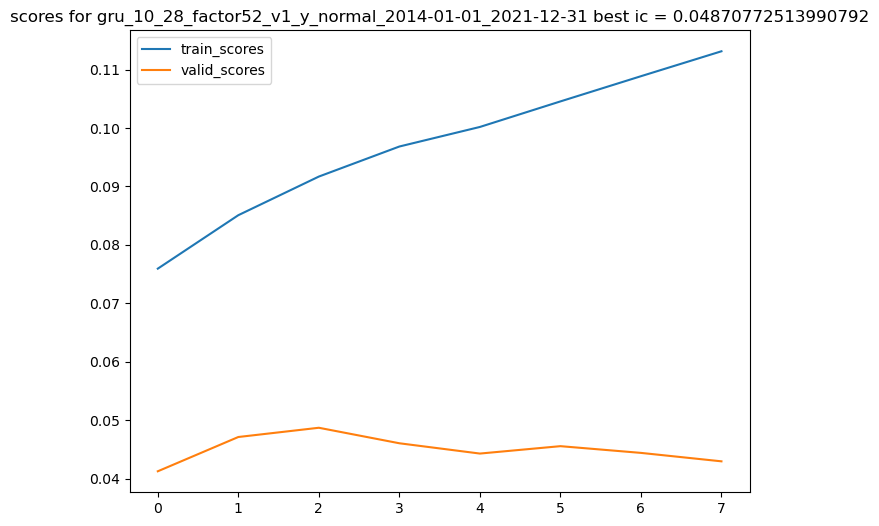

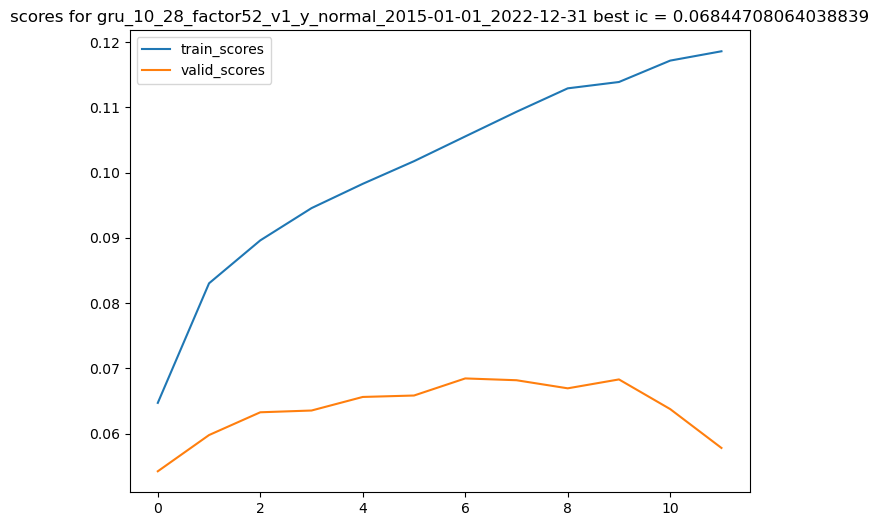

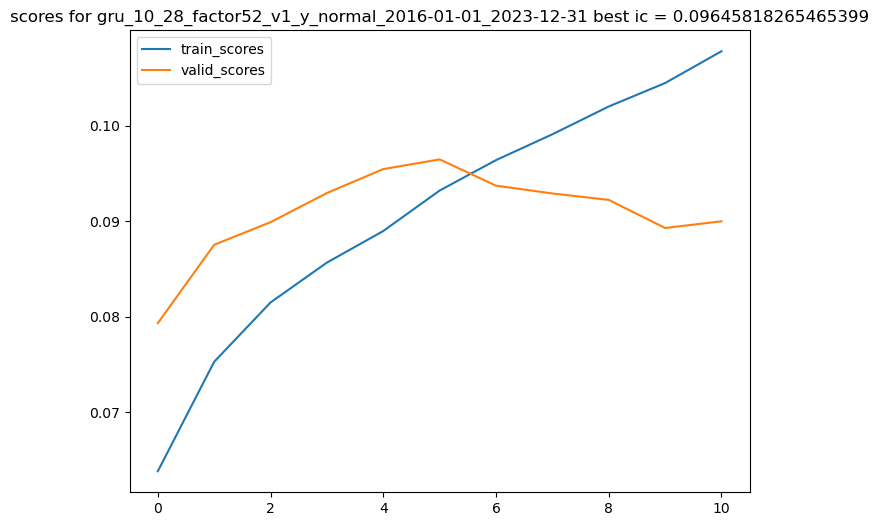

In [12]:
df_y_pred, loss = gru_model_rolling(df=raw_data,
                                    train_start_date=train_start_date,
                                    train_end_date=train_end_date,
                                    test_start_date=test_start_date,
                                    test_end_date=test_end_date,
                                    test_final_date=test_final_date,
                                    jump=1,
                                    times=8,
                                    train_period_years=8,
                                    batch_size=batch_size,
                                    try_label=try_label,
                                    sep_len=seq_len,
                                    step=step)


In [13]:
loss

0.0756375

In [14]:
df_y_pred

stock_code,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,688652.SH,688657.SH,688671.SH,688693.SH,688695.SH,688702.SH,688709.SH,688716.SH,688719.SH,688720.SH
datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-03,1.831651,-0.985674,2.259882,3.046733,-2.904474,0.193522,-1.322786,-1.732668,-0.307798,-1.836178,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,1.773250,-1.065218,2.455128,2.643087,-2.961700,0.175774,-0.848704,-1.371117,-0.221243,-2.795667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,1.543077,-1.110940,2.441386,1.974296,-2.714944,0.278955,-0.761911,-1.440583,0.751457,-2.893929,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,1.268659,-1.179348,2.480324,2.234115,-2.128524,0.438276,0.483115,-2.015612,0.906487,-2.765491,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-09,0.934802,-1.336340,2.388555,1.673664,-2.242399,0.855597,-0.212010,-1.855708,0.887265,-4.017296,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-29,1.253492,-5.363218,-5.054759,NaN,3.711841,-8.580568,-0.233335,2.407009,-10.179918,1.956861,...,NaN,4.479473,3.274039,2.627931,3.560286,-6.877115,-4.586972,5.337053,3.521584,NaN
2024-07-30,2.744095,-4.463482,-4.971911,NaN,3.685553,-8.343585,0.163857,2.184474,-10.738372,2.293529,...,NaN,4.322151,3.276046,2.505889,3.668921,-8.247171,-3.870478,5.554869,4.040788,NaN
2024-07-31,1.581830,-2.804133,-4.606480,NaN,3.406464,-7.841269,0.061178,2.332318,-10.640379,3.576255,...,NaN,4.103227,3.433999,0.806144,3.500893,-6.584384,-3.556251,5.422047,3.880732,NaN


# 4.回测

## 4.1回测1d

[1266774:MainThread](2024-10-28 19:58:46,289) INFO - AlphaSim.AlphaBacktestHF - [AlphaSim_hf.py:55] - Initialization
[1266774:MainThread](2024-10-28 19:58:46,434) INFO - AlphaSim.AlphaBacktestHF - [AlphaSim_hf.py:98] - Use old y, start prepare_y


return_future is aquired
RankIC is calculated


[1266774:MainThread](2024-10-28 19:59:30,178) INFO - AlphaSim.AlphaBacktestHF - [AlphaSim_hf.py:394] - pic has been saved in /home/chenglei/higgs_quant/back_test_results/group_test_results/gru_10_28_factor52_v1_y_normal_y_pred_17_24.png


gru_10_28_factor52_v1_y_normal_y_pred_17_24


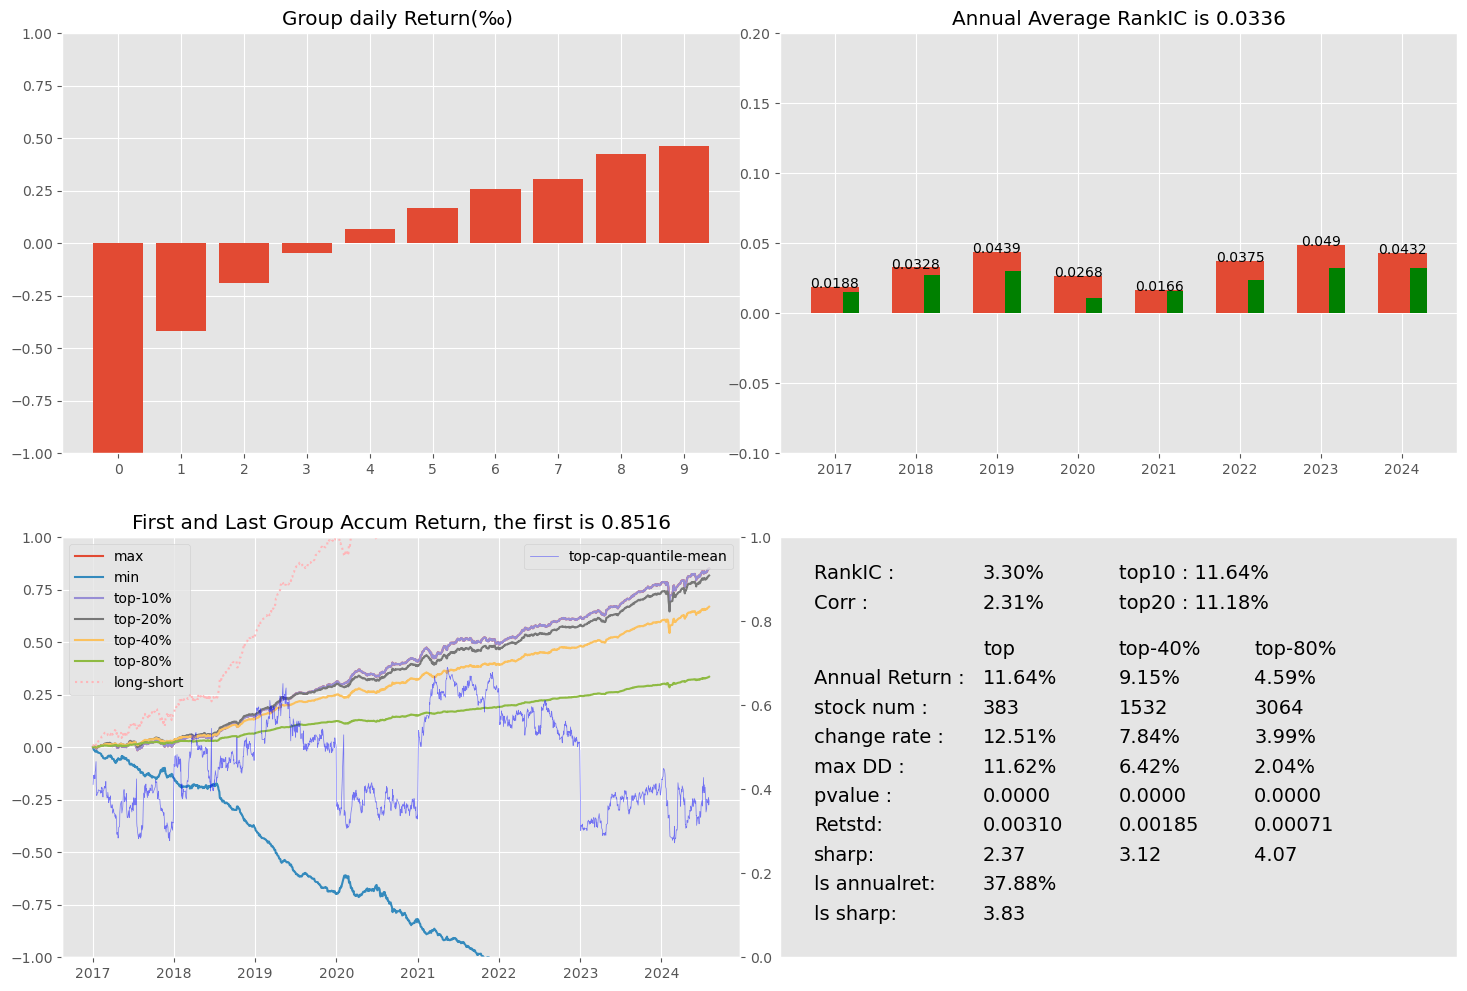

strategy_test func time_cost -> 44.33222818374634


In [15]:
import pandas as pd
import numpy as np
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append('/home/chenglei/higgs_quant')

from AlphaSim.AlphaSim_hf import AlphaBacktestHF
OUTPUT_BASEDIR =  "/home/chenglei/higgs_quant/back_test_results/"

class BaseConfig():
    alpha_name = 'default'
    money = 20000000
    output_basedir = OUTPUT_BASEDIR
    # const_dir =  "/mnt/weka/home/gubingchuan/data_gubc/home/gubingchuan/const"
    const_dir = "/mnt/weka/home/chenglei/higgs_quant/const"
    init_y = False
    # ==================== buy_price 和 sell_price============================
    # 可选close, twap, twap_f2hh, twap_f4hh, twap_56hh, twap_34hh, twap_l4hh
    buy_price = "df_close_09_13_twap_14_24_close"
    sell_price = "df_close_09_13_twap_14_24_close"
    period = 1 #调仓周期改为一天
    # =====================基准===============================================
    # 可选"HS300", "ZZ500", "Ashare", null,
    benchmark = "Ashare" # 注意，这里的Ashare 指股票池内股票简单平均
    # =====================是否考虑交易限制====================================
    # 可选'lock', 'remove', 'free', 分别代表：
    # lock：锁住涨跌停的仓位
    # remove：涨跌停的股票置为0
    # free：不考虑涨跌停限制
    trade_constrain = 'remove'
    # =====================时间===============================================
    start_date = "2014-01-01"
    end_date = "2024-08-31"
    # ======================对alpha的处理=====================================
    # 强制市场中性
    is_market_neutral = True
    # 市值分层中性 # 暂时没用
    is_cap_neutral = False # 暂时没用
    # 行业中性,目前行业数据更新到 202400630
    is_industry_neutral = False
    # 选取部分行业回测，空列表[]默认为所有行业，行业标准参考申万 1 级
    is_part_industry = []
    # ======================是否做分组测试=====================================
    is_group_test = False
    
Backtest = AlphaBacktestHF(BaseConfig)
result = Backtest.strategy_test(
    df_y_pred,
    ngrp=10,
    name=f'{try_label}_y_pred_17_24')


[1266774:MainThread](2024-10-28 19:59:30,957) INFO - AlphaSim.AlphaBacktestHF - [AlphaSim_hf.py:55] - Initialization
[1266774:MainThread](2024-10-28 19:59:31,030) INFO - AlphaSim.AlphaBacktestHF - [AlphaSim_hf.py:98] - Use old y, start prepare_y


return_future is aquired
RankIC is calculated


[1266774:MainThread](2024-10-28 20:00:14,306) INFO - AlphaSim.AlphaBacktestHF - [AlphaSim_hf.py:394] - pic has been saved in /home/chenglei/higgs_quant/back_test_results/group_test_results/gru_10_28_factor52_v1_y_normal_y_pred_17_24.png


gru_10_28_factor52_v1_y_normal_y_pred_17_24


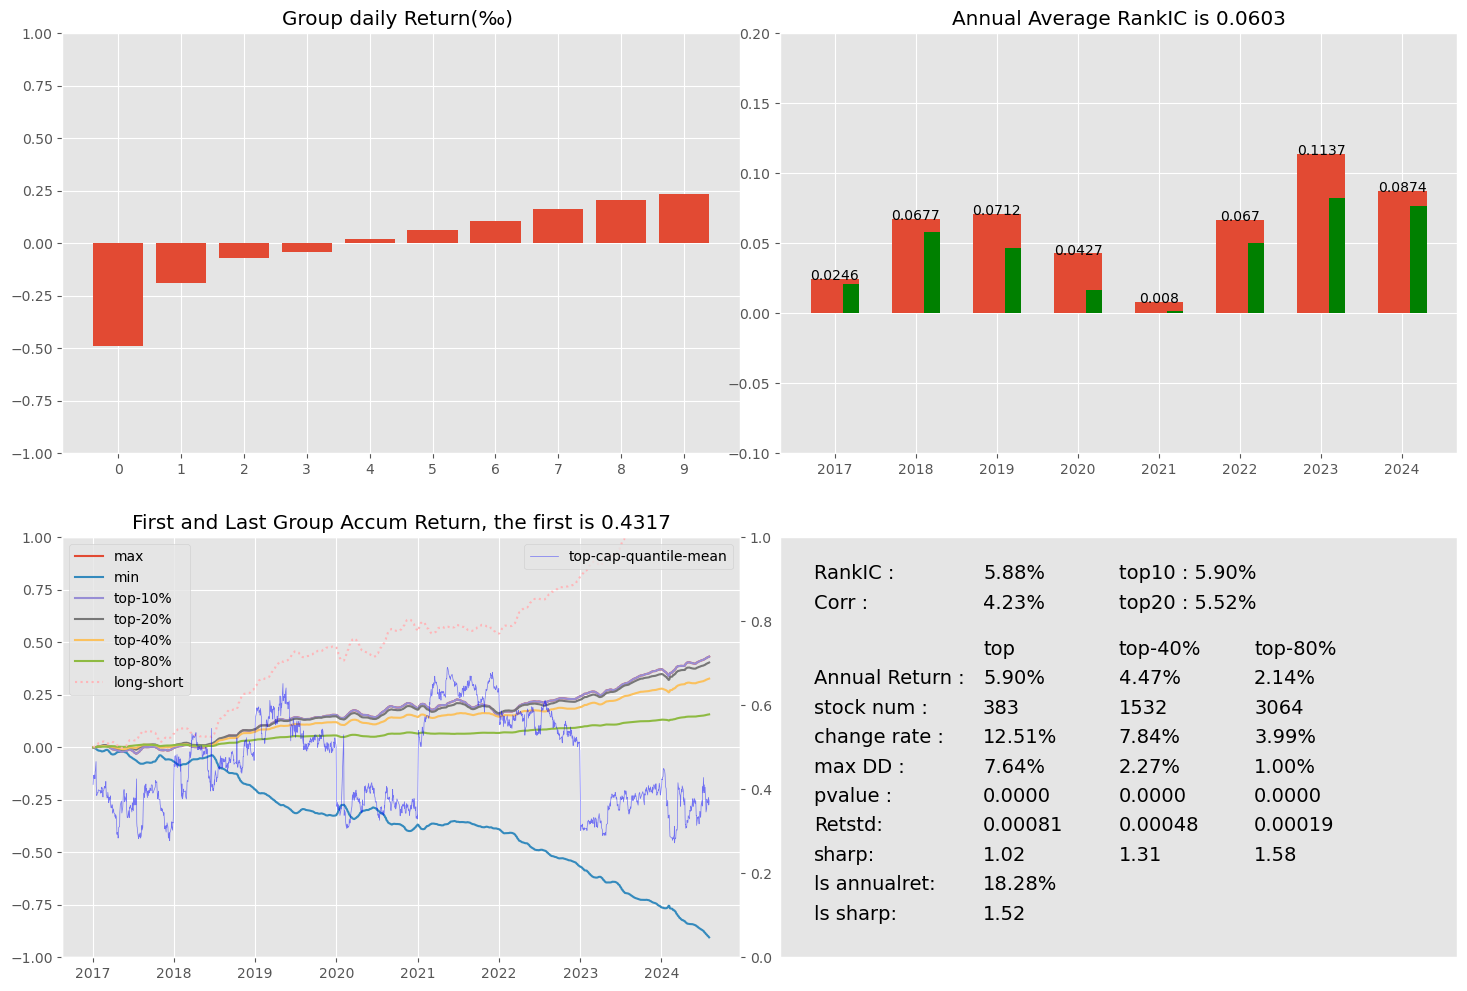

strategy_test func time_cost -> 43.78675627708435


In [16]:
import pandas as pd
import numpy as np
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append('/home/chenglei/higgs_quant')

from AlphaSim.AlphaSim_hf import AlphaBacktestHF
OUTPUT_BASEDIR =  "/home/chenglei/higgs_quant/back_test_results/"

class BaseConfig():
    alpha_name = 'default'
    money = 20000000
    output_basedir = OUTPUT_BASEDIR
    # const_dir =  "/mnt/weka/home/gubingchuan/data_gubc/home/gubingchuan/const"
    const_dir = "/mnt/weka/home/chenglei/higgs_quant/const"
    init_y = False
    # ==================== buy_price 和 sell_price============================
    # 可选close, twap, twap_f2hh, twap_f4hh, twap_56hh, twap_34hh, twap_l4hh
    buy_price = "df_close_09_13_twap_14_24_close"
    sell_price = "df_close_09_13_twap_14_24_close"
    period = 20 #调仓周期改为一天
    # =====================基准===============================================
    # 可选"HS300", "ZZ500", "Ashare", null,
    benchmark = "Ashare" # 注意，这里的Ashare 指股票池内股票简单平均
    # =====================是否考虑交易限制====================================
    # 可选'lock', 'remove', 'free', 分别代表：
    # lock：锁住涨跌停的仓位
    # remove：涨跌停的股票置为0
    # free：不考虑涨跌停限制
    trade_constrain = 'remove'
    # =====================时间===============================================
    start_date = "2014-01-01"
    end_date = "2024-08-31"
    # ======================对alpha的处理=====================================
    # 强制市场中性
    is_market_neutral = True
    # 市值分层中性 # 暂时没用
    is_cap_neutral = False # 暂时没用
    # 行业中性,目前行业数据更新到 202400630
    is_industry_neutral = False
    # 选取部分行业回测，空列表[]默认为所有行业，行业标准参考申万 1 级
    is_part_industry = []
    # ======================是否做分组测试=====================================
    is_group_test = False
    
Backtest = AlphaBacktestHF(BaseConfig)
result = Backtest.strategy_test(
    df_y_pred,
    ngrp=10,
    name=f'{try_label}_y_pred_17_24')
